# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer 
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel("obesitymerge.xlsx")

In [3]:
df.sample(10)

,PatientId,Zone,State,District,Age,Gender,Waist,Height,Weight,DiabetesSelfDecl,...,BmiWcRiskScore,Waistscore,IDRSAge,IDRSFamilyH,IDRSBmi,IDRSBmiWc,IDRSPhysicalActivity,IDRS,IDRSWithBMI,IDRSWithBMIWC
6454,15944,S,Karnataka,Bangalore,62,Male,105.0,157,75,Diabetic,...,4,20,30,20,20,30,30,100,100,110
3719,9748,E,Jharkhand,Ranchi,39,Male,94.0,168,69,Normal,...,3,10,20,0,10,20,20,50,50,60
4465,11705,NW,JammuandKashmir,Samba,32,Female,88.0,152,64,Normal,...,4,10,0,0,20,30,30,40,50,60
7440,17778,S,TamilNadu,Madurai,34,Female,81.0,159,81,Diabetic,...,4,10,0,10,20,30,30,50,60,70
3671,9646,S,AndamanAndNicobar,PortBlair,29,Female,76.0,150,44,Normal,...,1,0,0,0,0,0,30,30,30,30
5723,14516,E,Orissa,Balasore,52,Male,91.0,155,55,Diabetic,...,2,10,30,10,0,10,30,80,70,80
2103,5403,W,Maharashtra,Nagpur,60,Female,99.0,153,68,Normal,...,4,20,30,0,20,30,30,80,80,90
7321,17567,W,Gujarat,Navsari,61,Male,96.0,163,65,Diabetic,...,3,10,30,0,10,20,30,70,70,80
7196,17348,C,MadhyaPradesh,Gwalior,56,Male,77.0,160,54,Diabetic,...,1,0,30,0,0,0,20,50,50,50
4156,10859,NW,JammuandKashmir,Samba,60,Male,94.0,169,62,Normal,...,2,10,30,0,0,10,30,70,60,70


# Data Preprocessing

In [4]:
train=df
target = 'DiabetesCalc'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7496 entries, 0 to 7495
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PatientId             7496 non-null   int64  
 1   Zone                  7496 non-null   object 
 2   State                 7496 non-null   object 
 3   District              7496 non-null   object 
 4   Age                   7496 non-null   int64  
 5   Gender                7496 non-null   object 
 6   Waist                 7495 non-null   float64
 7   Height                7496 non-null   int64  
 8   Weight                7496 non-null   int64  
 9   DiabetesSelfDecl      7496 non-null   object 
 10  Diafather             7496 non-null   int64  
 11  Diamother             7496 non-null   int64  
 12  Moderate              7496 non-null   int64  
 13  Vigorous              7496 non-null   int64  
 14  Dailyphysica          7496 non-null   int64  
 15  Hlba1c               

In [6]:
# dropping ALL duplicate values
train.drop_duplicates(keep = False, inplace = True)

In [7]:
#Simple preprocessing
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Zone 7
State 29
District 55
Age 65
Gender 2
Waist 81
Height 71
Weight 84
DiabetesSelfDecl 2
Diafather 2
Diamother 2
Moderate 7
Vigorous 7
Dailyphysica 6
Hlba1c 119
DiabetesCalc 3
Diabetes 2
ClinicalNotes 6
WcRiskScore 5
BmiRiskScore 5
BmiWcRiskScore 6
Waistscore 3
IDRSAge 3
IDRSFamilyH 3
IDRSBmi 3
IDRSBmiWc 4
IDRSPhysicalActivity 3
IDRS 11
IDRSWithBMI 11
IDRSWithBMIWC 12
Set 3


In [8]:
train=train.drop(['PatientId', 'Zone', 'State', 'District','Hlba1c', 'DiabetesSelfDecl'],axis=1)

In [9]:
print(train.columns)

Index(['Age', 'Gender', 'Waist', 'Height', 'Weight', 'Diafather', 'Diamother',
       'Moderate', 'Vigorous', 'Dailyphysica', 'DiabetesCalc', 'Diabetes',
       'ClinicalNotes', 'Bmi', 'WcRiskScore', 'BmiRiskScore', 'BmiWcRiskScore',
       'Waistscore', 'IDRSAge', 'IDRSFamilyH', 'IDRSBmi', 'IDRSBmiWc',
       'IDRSPhysicalActivity', 'IDRS', 'IDRSWithBMI', 'IDRSWithBMIWC', 'Set'],
      dtype='object')


In [10]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "Normal"
train.loc[train[target]==1, target] = "Prediabetic"
train.loc[train[target]==2, target] = "Diabetic"

In [11]:
#Define categorical features for categorical embeddings
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [12]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)

## Training

In [13]:
import time

In [14]:
start_clf= time.time()

In [15]:
#Network parameters
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [16]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [17]:
print(features)

['Age', 'Gender', 'Waist', 'Height', 'Weight', 'Diafather', 'Diamother', 'Moderate', 'Vigorous', 'Dailyphysica', 'Diabetes', 'ClinicalNotes', 'Bmi', 'WcRiskScore', 'BmiRiskScore', 'BmiWcRiskScore', 'Waistscore', 'IDRSAge', 'IDRSFamilyH', 'IDRSBmi', 'IDRSBmiWc', 'IDRSPhysicalActivity', 'IDRS', 'IDRSWithBMI', 'IDRSWithBMIWC']


In [18]:
print(target)

DiabetesCalc


In [19]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [20]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [21]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
    )
    save_history.append(clf.history["valid_accuracy"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 1.34318 | train_accuracy: 0.41635 | valid_accuracy: 0.42818 |  0:00:04s
epoch 1  | loss: 0.81284 | train_accuracy: 0.47521 | valid_accuracy: 0.46238 |  0:00:04s
epoch 2  | loss: 0.6232  | train_accuracy: 0.64069 | valid_accuracy: 0.63611 |  0:00:05s
epoch 3  | loss: 0.47003 | train_accuracy: 0.73636 | valid_accuracy: 0.7565  |  0:00:05s
epoch 4  | loss: 0.40742 | train_accuracy: 0.75974 | valid_accuracy: 0.74829 |  0:00:06s
epoch 5  | loss: 0.38436 | train_accuracy: 0.79688 | valid_accuracy: 0.77428 |  0:00:06s
epoch 6  | loss: 0.33305 | train_accuracy: 0.87697 | valid_accuracy: 0.86867 |  0:00:06s
epoch 7  | loss: 0.30719 | train_accuracy: 0.89488 | valid_accuracy: 0.89056 |  0:00:07s
epoch 8  | loss: 0.30854 | train_accuracy: 0.95407 | valid_accuracy: 0.95075 |  0:00:07s
epoch 9  | loss: 0.29165 | train_accuracy: 0.96717 | valid_accuracy: 0.96854 |  0:00:07s
epoch 10 | loss: 0.26532 | train_accuracy: 0.97894 | valid_accuracy: 0.98495 |  0:00:08s
epoch 11 | loss: 0.27

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.34318 | train_accuracy: 0.41635 | valid_accuracy: 0.42818 |  0:00:00s
epoch 1  | loss: 0.81284 | train_accuracy: 0.47521 | valid_accuracy: 0.46238 |  0:00:00s
epoch 2  | loss: 0.6232  | train_accuracy: 0.64069 | valid_accuracy: 0.63611 |  0:00:01s
epoch 3  | loss: 0.47003 | train_accuracy: 0.73636 | valid_accuracy: 0.7565  |  0:00:01s
epoch 4  | loss: 0.40742 | train_accuracy: 0.75974 | valid_accuracy: 0.74829 |  0:00:01s
epoch 5  | loss: 0.38436 | train_accuracy: 0.79688 | valid_accuracy: 0.77428 |  0:00:02s
epoch 6  | loss: 0.33305 | train_accuracy: 0.87697 | valid_accuracy: 0.86867 |  0:00:02s
epoch 7  | loss: 0.30719 | train_accuracy: 0.89488 | valid_accuracy: 0.89056 |  0:00:02s
epoch 8  | loss: 0.30854 | train_accuracy: 0.95407 | valid_accuracy: 0.95075 |  0:00:03s
epoch 9  | loss: 0.29165 | train_accuracy: 0.96717 | valid_accuracy: 0.96854 |  0:00:03s
epoch 10 | loss: 0.26532 | train_accuracy: 0.97894 | valid_accuracy: 0.98495 |  0:00:04s
epoch 11 | loss: 0.27

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


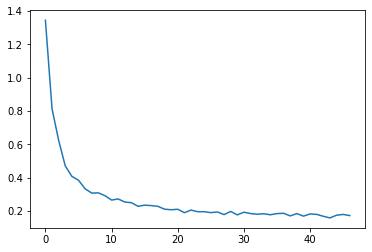

In [22]:
# plot losses
plt.plot(clf.history['loss'])

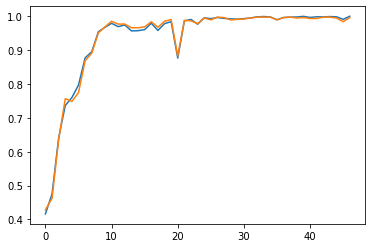

In [23]:
# plot auc
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

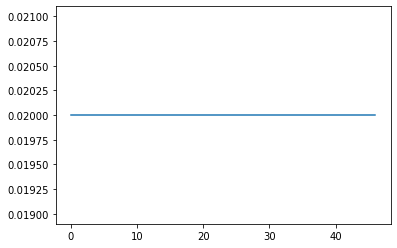

In [24]:
# plot learning rates
plt.plot(clf.history['lr'])

### Predictions

In [25]:
y_pred = clf.predict(X_test)

In [26]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [27]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [28]:
cm = confusion_matrix(y_test, y_pred) 
accuracy=metrics.recall_score(y_test,y_pred,average='micro')

In [29]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

Accuracy =  0.997275204359673
-
[[169   0   0]
 [  0 217   0]
 [  0   2 346]]
-
              precision    recall  f1-score   support

    Diabetic       1.00      1.00      1.00       169
      Normal       0.99      1.00      1.00       217
 Prediabetic       1.00      0.99      1.00       348

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734

-


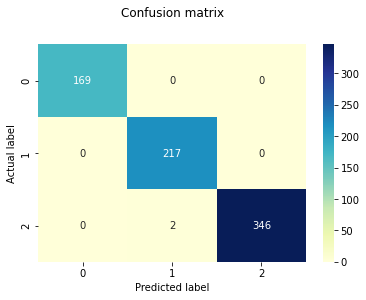

0.9983974002682734


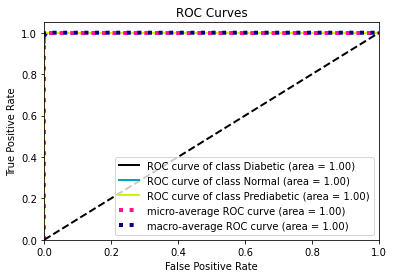

In [30]:
print('Accuracy = ', accuracy_score(y_test, y_pred))
print('-')
print(confusion_matrix(y_test,y_pred))
print('-')
print(classification_report(y_test,y_pred))
print('-')

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print(multiclass_roc_auc_score(y_test, y_pred))

from sklearn.metrics import roc_curve
y_pred_keras = clf.predict_proba(X=X_test)
import scikitplot as skplt
plot = skplt.metrics.plot_roc(y_test, y_pred_keras)
plt.show()

In [31]:
print(multiclass_roc_auc_score(y_test, y_pred))

0.9983974002682734


In [32]:
end_clf= time.time()
time_clf = end_clf-start_clf
print('Time taken:',time_clf)

Time taken: 39.976903438568115


In [33]:
print('Time taken in minutes:',time_clf/60)

Time taken in minutes: 0.6662817239761353


In [34]:
clf.feature_importances_

array([0.01514505, 0.03155911, 0.00819443, 0.00504365, 0.00722619,
       0.00964707, 0.02549988, 0.00728321, 0.00664424, 0.00437787,
       0.19746948, 0.50570066, 0.00936008, 0.0011338 , 0.00409343,
       0.01195655, 0.00466194, 0.0333746 , 0.01020127, 0.00398882,
       0.04555865, 0.00329338, 0.0130168 , 0.02240722, 0.01316263])

#### Local Explainability and Masks

In [35]:
explain_matrix, masks = clf.explain(X_test)

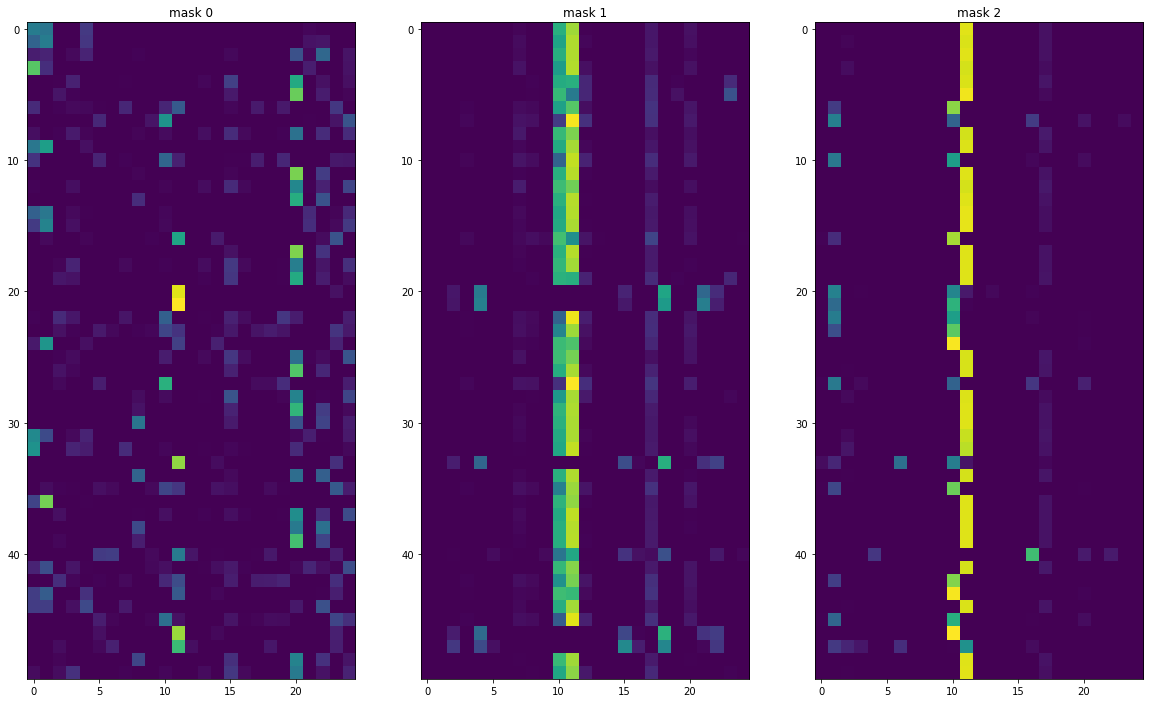

In [36]:
fig, axs = plt.subplots(1,3,figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")